In [1]:
import sys
sys.path.append('../')

import numpy as np
import pygme

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

## Reproduce Fig. 1(b) in Cerjan and Fan, PRA (2017)

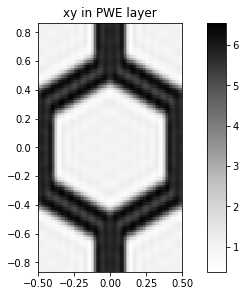

In [3]:
# Initialize a lattice
lattice = pygme.Lattice('hexagonal')
# Initialize a layer
layer = pygme.ShapesLayer(lattice, eps_b = 2.4**2)
# Add a shape to this layer 
l = 1/np.sqrt(3) # l-parameter in his paper in units of lattice constant a (which is a = 1 in my case)
hexagon = pygme.Hexagon(eps = 1, a = (1-0.1818*l)/2)
hexagon.rotate(np.pi/6)
layer.add_shape(hexagon)

# Initialize the PWE 
pwe = pygme.PlaneWaveExp(layer, gmax=5)
pwe.plot_overview_ft()

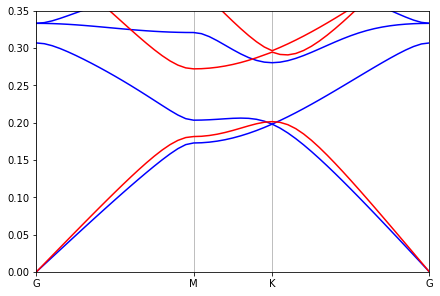

In [4]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm*l, 'b')
plt.plot(freqs_te*l, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Optimize the band gap with a supercell and autograd

In [5]:
import autograd.numpy as npa
from autograd import grad
pygme.set_backend('autograd')

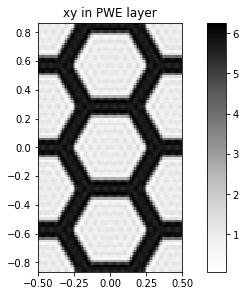

In [7]:
def pwe_cerjan(params, gmax=10):
    # Make a PWE simulation with 3 holes in the elementary cell
    # Initialize a lattice
    lattice = pygme.Lattice('hexagonal')
    # Initialize a layer
    layer = pygme.ShapesLayer(lattice, eps_b = 2.4**2)
    a_sc = np.sqrt(3)
    hex1 = pygme.Hexagon(eps=1, a = params[0]/a_sc)
    hex2 = pygme.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=0.5/a_sc, a=params[1]/a_sc)
    hex3 = pygme.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=-0.5/a_sc, a=params[2]/a_sc)
    # Make a supercell
    layer.add_shape(hex1, hex2, hex3)
    
    return pygme.PlaneWaveExp(layer, gmax=gmax)

# Initialize the PWE that should match the simulation above
l = 1/np.sqrt(3)
params = np.ones(3)*(1-0.1818*l)/2
pwe = pwe_cerjan(params)
pwe.plot_overview_ft()

## Reproduce Fig. 1(d) in Cerjan and Fan, PRA (2017)

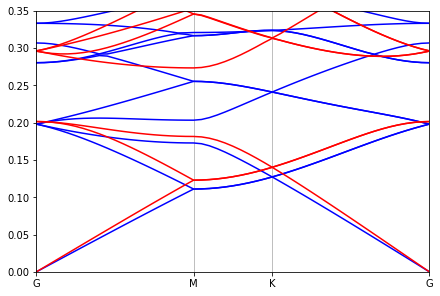

In [8]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Reproduce something like Fig. 1(f) in Cerjan and Fan, PRA (2017)

[0.38 0.53 0.53]


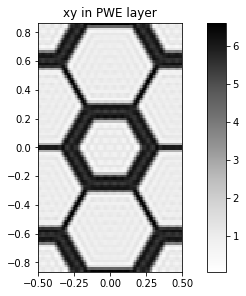

In [9]:
params = np.array([0.38, 0.53, 0.53])
print(params)
pwe = pwe_cerjan(params, gmax=10)
pwe.plot_overview_ft()

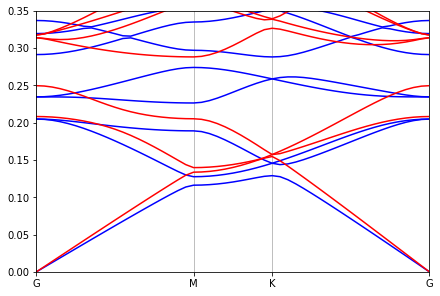

In [10]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

In [11]:
# Function to return the band-gap size around a given center frequency
def bg_size(freqs_te, freqs_tm, freq_cent = 0.29*3):
    freqs_all = npa.hstack((freqs_te.flatten(), freqs_tm.flatten()))
    freq_min = npa.amax(npa.where(freqs_all < freq_cent, freqs_all, 0))
    freq_max = npa.amin(npa.where(freqs_all > freq_cent, freqs_all, 1e6))
    return freq_max - freq_min

print('Band gap size:', bg_size(freqs_te, freqs_tm)) 

Band gap size: 0.0016516107560572424


In [13]:
# Now let's try to optimize params[0] and params[1], keeping params[1] = params[2]

def of_bg(ps):
    # Initialize the PWE 
    pwe = pwe_cerjan([ps[0], ps[1], ps[1]])

    # Run the PWE for both polarizations
    pwe.run(kpoints=path.kpoints, pol='te')
    freqs_te = pwe.freqs
    pwe.run(kpoints=path.kpoints, pol='tm')
    freqs_tm = pwe.freqs
    
    # And return the band gap size as objective function
    # We sample several different center frequencies and take the largest bandgap found
    cfs = npa.arange(0.25, 0.32, 0.01)*3
    bgs = []
    for cf in cfs:
        bg = bg_size(freqs_te, freqs_tm, freq_cent=cf)
        bgs.append(bg)

    return npa.amax(npa.array(bgs))

In [14]:
# Let's first test the gradient
from pygme.utils import grad_num
grad_test = grad(of_bg)
print(of_bg(params))

print('Autograd gradient:  ', grad_test(params))
print('Numerical gradient: ', grad_num(of_bg, params))

0.042287807642300224
Autograd gradient:   [-0.27211897  1.6198893   0.        ]
Numerical gradient:  [-0.28305741  1.61194703  0.        ]


In [15]:
from pygme.optimizers import adam_optimize

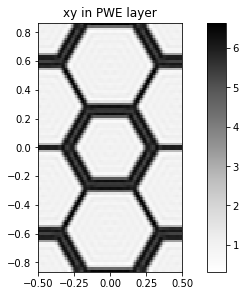

In [16]:
# Pick some starting point and show what the supercell is about
params = np.array([0.42, 0.53, 0.53])
pwe = pwe_cerjan(params)
pwe.plot_overview_ft()

In [17]:
# Run the optimization
(p_opt, ofs) = adam_optimize(of_bg, params, grad_test, step_size = 1e-3, Nsteps = 100, 
                             options = {'direction': 'max', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.02849879947576195
Parameters are:       [ 0.4200  0.5300  0.5300]
At iteration 1 :
Objective value is:   0.0304801585533665
Parameters are:       [ 0.4190  0.5310  0.5300]
At iteration 2 :
Objective value is:   0.032490505735352726
Parameters are:       [ 0.4180  0.5320  0.5300]
At iteration 3 :
Objective value is:   0.03453041798961576
Parameters are:       [ 0.4170  0.5330  0.5300]
At iteration 4 :
Objective value is:   0.035300606398097734
Parameters are:       [ 0.4160  0.5340  0.5300]
At iteration 5 :
Objective value is:   0.03494787081742401
Parameters are:       [ 0.4150  0.5347  0.5300]
At iteration 6 :
Objective value is:   0.03482296897577419
Parameters are:       [ 0.4141  0.5351  0.5300]
At iteration 7 :
Objective value is:   0.034873713912729754
Parameters are:       [ 0.4131  0.5353  0.5300]
At iteration 8 :
Objective value is:   0.035061334496997554
Parameters are:       [ 0.4122  0.5353  0.5300]
At iteration 9 :
Objective value i

At iteration 76 :
Objective value is:   0.04244242983576685
Parameters are:       [ 0.3753  0.5295  0.5300]
At iteration 77 :
Objective value is:   0.04244776320619348
Parameters are:       [ 0.3752  0.5293  0.5300]
At iteration 78 :
Objective value is:   0.042500119384032975
Parameters are:       [ 0.3751  0.5293  0.5300]
At iteration 79 :
Objective value is:   0.042493430161427814
Parameters are:       [ 0.3750  0.5293  0.5300]
At iteration 80 :
Objective value is:   0.04242825137593742
Parameters are:       [ 0.3747  0.5294  0.5300]
At iteration 81 :
Objective value is:   0.04238418949842304
Parameters are:       [ 0.3746  0.5295  0.5300]
At iteration 82 :
Objective value is:   0.04237553172145536
Parameters are:       [ 0.3745  0.5295  0.5300]
At iteration 83 :
Objective value is:   0.0423990329972147
Parameters are:       [ 0.3744  0.5294  0.5300]
At iteration 84 :
Objective value is:   0.0424516210664827
Parameters are:       [ 0.3744  0.5293  0.5300]
At iteration 85 :
Objective 

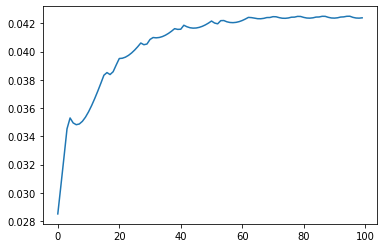

In [18]:
import matplotlib.pyplot as plt
plt.plot(ofs)
plt.show()

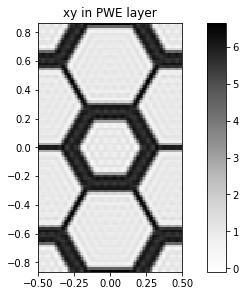

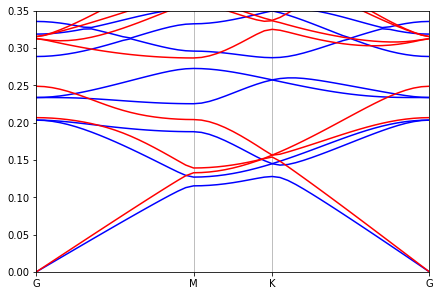

In [19]:
pwe = pwe_cerjan(p_opt)
pwe.plot_overview_ft()

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()